In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')
import scanpy as sc
import numpy as np
import commot as ct
import pandas as pd
from spaceoracle.oracles import BaseTravLR
import matplotlib.pyplot as plt
import celloracle as co

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
adata = sc.read_h5ad('../../data/slideseq/day3_1.h5ad')

In [12]:
def expand_paired_interactions(df):
    expanded_rows = []
    for _, row in df.iterrows():
        ligands = row['ligand'].split('_')
        receptors = row['receptor'].split('_')
        
        for ligand in ligands:
            for receptor in receptors:
                new_row = row.copy()
                new_row['ligand'] = ligand
                new_row['receptor'] = receptor
                expanded_rows.append(new_row)
    
    return pd.DataFrame(expanded_rows)

In [13]:
df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='mouse', 
        signaling_type="Secreted Signaling"
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)


In [14]:
ilr2_df =df_ligrec.query('receptor.str.contains("Il2") or ligand.str.contains("Il2")')
genes_of_interest = list(np.unique(ilr2_df.ligand.unique().tolist() + ilr2_df.receptor.unique().tolist()))
# len(genes_of_interest)
genes_of_interest = genes_of_interest + ['Bach2', 'Prdm1', 'Bcl6', 'Foxp3', 'Satb1', 'Id2']

In [15]:
n_top_genes = 3000
min_cells = 10
min_counts = 250

In [16]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
adata = adata[:, ~adata.var["mt"]]

sc.pp.filter_genes(adata, min_cells=min_cells)
adata.layers["raw_count"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes)

adata = adata[:, (adata.var.highly_variable | adata.var_names.isin(genes_of_interest))]
adata.layers["normalized_count"] = adata.to_df().values

In [17]:
adata.shape

(11567, 3020)

In [18]:
%%time
plt.rcParams["figure.figsize"] = [6, 6]
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')
sc.tl.paga(adata, groups='rctd_cluster')
sc.pl.paga(adata)
plt.show()
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)

CPU times: user 1min 22s, sys: 2.51 s, total: 1min 25s
Wall time: 1min 22s


In [19]:
oracle = co.Oracle()

In [22]:
adata.X.toarray().max()

5.3231463

In [28]:
adata.X = adata.layers["raw_count"].copy()

In [29]:
adata.X.toarray().max()

521.0

In [27]:
del adata.uns['log1p']

In [30]:
oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="rctd_cluster",
    embedding_name="X_draw_graph_fr"
)

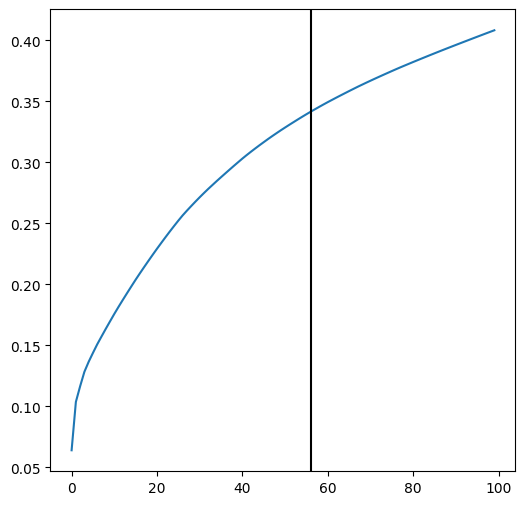

56


In [32]:
%matplotlib inline

# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [35]:
adata.layers["raw_count"].toarray().sum(0)

array([509.,  13., 630., ...,  33.,  36., 242.], dtype=float32)

In [33]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :11567
Auto-selected k is :289


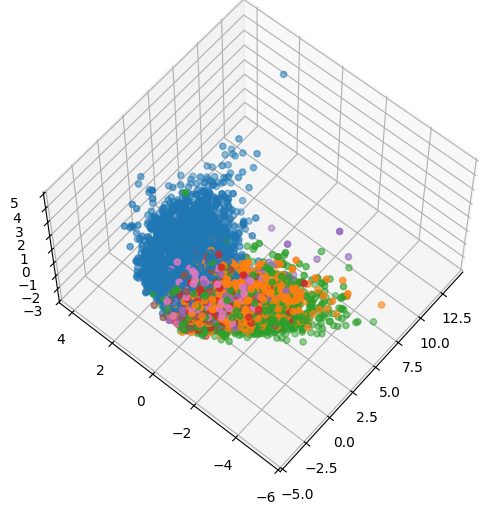

In [34]:
oracle.plot_pca()

In [12]:
# %%time

# pcs = BaseTravLR.perform_PCA(adata)
# BaseTravLR.knn_imputation(adata, pcs)

CPU times: user 56.1 s, sys: 6.55 s, total: 1min 2s
Wall time: 8.79 s


In [36]:
%%time 

oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

CPU times: user 6min 56s, sys: 4.34 s, total: 7min 1s
Wall time: 1min 10s


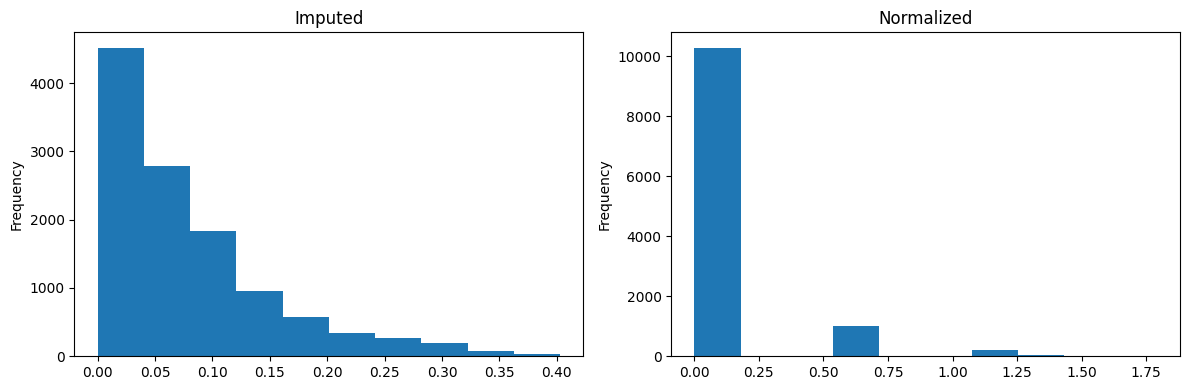

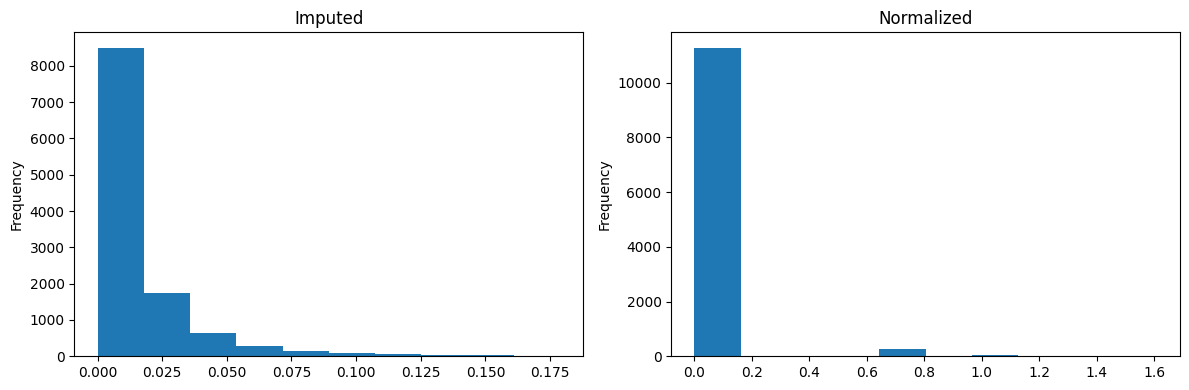

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
oracle.adata.to_df(layer='imputed_count')['Pax5'].plot.hist(ax=ax1, title='Imputed')
oracle.adata.to_df(layer='normalized_count')['Pax5'].plot.hist(ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
oracle.adata.to_df(layer='imputed_count')['Il2ra'].plot.hist(ax=ax1, title='Imputed')
oracle.adata.to_df(layer='normalized_count')['Il2ra'].plot.hist(ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()


In [61]:
imp_vals = oracle.adata.to_df(layer='imputed_count').values.flatten()
norm_vals = oracle.adata.to_df(layer='normalized_count').values.flatten()

In [64]:
norm_vals.min(), norm_vals.mean(), norm_vals.max()

(0.0, 0.023075009, 6.2576675)

In [65]:
imp_vals.min(), imp_vals.mean(), imp_vals.max()

(0.0, 0.020243490013940886, 3.0394810701238684)

In [15]:
adata.layers['raw_count'].toarray().max()

521.0

In [73]:
adata = oracle.adata.copy()

In [74]:
adata.obs = adata.obs.drop(columns=['n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'])

adata.var.drop(columns=adata.var.columns, inplace=True)

del adata.uns['rctd_cluster_colors']
del adata.uns['hvg']
del adata.uns['cluster_colors']

In [75]:
import json
with open('../../data/celltype_assign.json', 'r') as f:
    cell_type_mapping = json.load(f)
adata.obs['rctd_celltypes'] = adata.obs['rctd_cluster'].astype(str).map(cell_type_mapping)

In [77]:
adata

AnnData object with n_obs × n_vars = 11567 × 3020
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'pca', 'neighbors', 'diffmap_evals', 'paga', 'rctd_cluster_sizes', 'draw_graph', 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'X_pca', 'X_diffmap', 'X_draw_graph_fr'
    varm: 'PCs'
    layers: 'raw_count', 'normalized_count', 'imputed_count'
    obsp: 'distances', 'connectivities'

In [78]:
adata.layers

Layers with keys: raw_count, normalized_count, imputed_count

In [82]:
adata.layers['imputed_count'].max(), adata.layers['normalized_count'].max(), adata.layers['raw_count'].max()

(3.0394810701238684, 6.2576675, 521.0)

In [83]:
adata.write_h5ad('../.cache/day3_lymph_rep_1.h5ad')

... storing 'rctd_celltypes' as categorical
